In [8]:
%load_ext autoreload

In [23]:
%autoreload 2
import os
from scipy.constants import k
import numpy as np
from resonance_utils import ResonanceKid, GapFinder

Fit consistently a set of resonances with increasing temperatures and save the obtained $Q_i$ to a file. Returns the frequency of the lowest temperature resonance. "polgrad" is the background polinomial's degree, while min and max define the fit limits in normalized frequency coordinates $x=\frac{f-f_0}{f_0}$. 

In [24]:
def fit_resonances(directory, filename_range, polgrad, min, max, phase=False, plot=False):
    basedir = "data"
    dir = os.path.join(basedir, directory)
    Tfull = np.linspace(40, 300, 53)
    T = []
    invQi = []
    invQiErr = []
    ini = None 

    for i in range(len(Tfull)):
        t = Tfull[i]
        filename = str(int(t))+filename_range
        if filename in os.listdir(dir):
            f = os.path.join(dir, filename)
            if os.path.isfile(f):

                if len(T) == 0:
                    res = ResonanceKid(f, polyorder=polgrad, fit_phase=phase)
                    res.f0_from_fit()
                    omega0 = res.f0_fit
                    res.fit()
                    ini = np.asarray(res.fit_result.values)
                    res.init_parameters = ini  
                else:
                    res = ResonanceKid(f, polyorder=polgrad, fit_phase=phase, init_parameters=ini)

                res.set_freq_cut(min, max)
                res.init_parameters = ini
                res.min_obj = res.minuit_obj()
                res.fit()
                if plot == True:
                    res.plot_fit()
                    print(f)

                T.append(t)
                invQi.append(res.invQvalues[1])
                invQiErr.append(res.invQerrors[1])
                ini = np.asarray(res.fit_result.values)
                
    if len(T)>0:
        data = np.column_stack([np.array(T), np.array(invQi), np.array(invQiErr)])
        file = open(os.path.join(dir, 'qi_vs_t.txt'), "w")
        np.savetxt(file, data, fmt = ['%d', '%.6E', '%.6E'])   
        file.close()
    return omega0

Fit the interal quality factors up to "Tlim" and save the results to a dictionary. 

In [25]:
def GapFit(Tlim, f0, key, FitResult, compare=False):
    basedir = "data"
    gap_obj = GapFinder(os.path.join(basedir, key[0], 'qi_vs_t.txt'), omega=f0, fit_type=key[2])
    gap_obj.set_T_limit(Tlim)
    gap_obj.plot_fit()

    delta0 = gap_obj.fit_result.values[0] * 1e-23
    print(delta0)
    deltaErr = gap_obj.fit_result.errors[0] * 1e-23
    tc = delta0 * (2/3.52)/k
    tcErr = deltaErr * (2/3.52)/k
    chi = round(gap_obj.chi2(), 3)

    if key[2] == 'kondo':
        TK = gap_obj.fit_result.values[1]
        TKErr = gap_obj.fit_result.errors[1]
        FitResult[key] = [tc, tcErr, delta0, deltaErr, TK, TKErr, chi]
    else:
        FitResult[key] = [tc, tcErr, delta0, deltaErr, chi]

    if compare == True:
        gap_obj.plot_fit_compare()
    print(f'* TempC = {round(tc, 5)} +/- {round(tcErr, 5)} mK')


Allowed ranges are 1-4, but each of them requires different parameters to obtain the best results

In [27]:
data = "data_28_02"
f_range = 'mK_range3.txt'
fit_type = 'kondo'
f0 = fit_resonances(data, f_range, 2, -0.0015, 0.0015, plot = False)

No fit found: doing it now


No fit found: doing it now


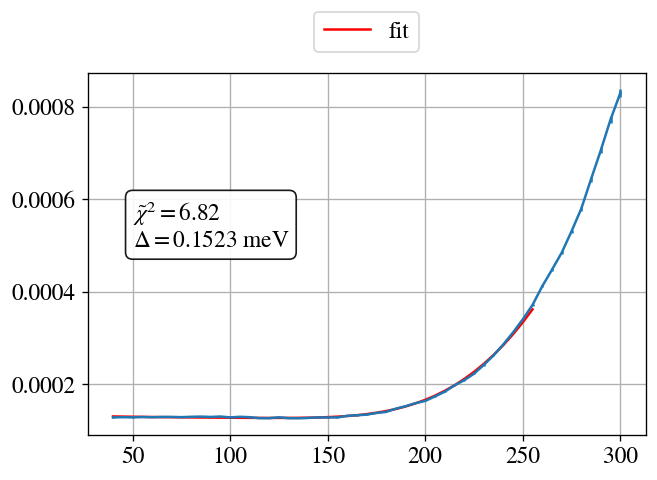

2.439971431443317e-23
* TempC = 1.00413 +/- 0.00047 mK


In [28]:
FitResult = {}
key = (data, f_range, fit_type)
GapFit(260, f0, key, FitResult)